In [2]:
# -*- coding:utf-8 -*-
import sys
import csv
import gzip
import json
import math
import datetime

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

import cv2
from PIL import Image

import os

import tdclient
import pandas_td as td
 
import google.cloud.storage
from google.cloud import storage

import re

import shutil


os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/tani_kyuichiro/nurve-cloud-98b3f-bb7c97f8fb03.json'

#%matplotlib inline


In [32]:
#メソッド

def json_paser(json):
    json_open = open(json, 'r')
    json_load = json.load(json_open)

    print(json_load)
    

#座標補正メソッド
def corrected_data(line):
    xy_lst = []
    #　小数点以下切り上げ
    #line[1] = math.ceil(float(line[1]))
    #line[2] = math.ceil(float(line[2]))
    x = math.ceil(float(line[2]))
    y = math.ceil(float(line[3]))
    
    #x軸補正
    #if line[1] < 0:
    if x < 0:    
        #xy_lst.append(line[1]*(-1) + 90)
        xy_lst.append(x*(-1) + 90)
    else:
        #xy_lst.append((line[1] - 90)*(-1))
        xy_lst.append((x - 90)*(-1))
     #補正無しX軸   
    #xy_lst.append(line[1])
    
    #y軸補正
    #fix_y = line[2] + 180
    fix_y = y + 180
    if fix_y > 360 :
        xy_lst.append(fix_y - 360)
    else:
        xy_lst.append(fix_y)
    return xy_lst

#json用座標補正メソッド
def corrected_data_json(line):
    xy_lst = []
    #　小数点以下切り上げ
    #line[1] = math.ceil(float(line[1]))
    #line[2] = math.ceil(float(line[2]))
    x = math.ceil(float(line[0]))
    y = math.ceil(float(line[1]))
    
    #x軸補正
    #if line[1] < 0:
    if x < 0:    
        #xy_lst.append(line[1]*(-1) + 90)
        xy_lst.append(x*(-1) + 90)
    else:
        #xy_lst.append((line[1] - 90)*(-1))
        xy_lst.append((x - 90)*(-1))
     #補正無しX軸   
    #xy_lst.append(line[1])
    
    #y軸補正
    #fix_y = line[2] + 180
    fix_y = y + 180
    if fix_y > 360 :
        xy_lst.append(fix_y - 360)
    else:
        xy_lst.append(fix_y)
    return xy_lst


#余白削除メソッド
def margin_cut(file_name='./hm.jpg',output_name='./hm_edge.png'):
    filename = file_name #'./image_3453421.jpg'
    img = cv2.imread(filename)
    img2 = cv2.imread(filename)

    # Grayscale に変換
    img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2 値化
    ret, thresh = cv2.threshold(img_gs, 250, 255, cv2.THRESH_BINARY)

    # 輪郭を取得
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # i = 1 は画像全体の外枠になるのでカウントに入れない
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in range(1, len(contours)):
        # ret の中身は (x, y, w, h)
        ret = cv2.boundingRect(contours[i])
        x1.append(ret[0])
        y1.append(ret[1])
        x2.append(ret[0] + ret[2])
        y2.append(ret[1] + ret[3])

    x1_min = min(x1)
    y1_min = min(y1)
    x2_max = max(x2)
    y2_max = max(y2)

    # 枠取りをした結果を表示
    #cv2.rectangle(img, (x1_min, y1_min), (x2_max, y2_max), (0, 255, 0), 2)
    #cv2.imwrite('cropped_edge_rectangle.jpg', img)

    # ギリギリで切り出し
    crop_img = img2[y1_min:y2_max, x1_min:x2_max]
    cv2.imwrite(output_name, crop_img)

#GCSからの画像データダウンロード
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    # bucket_name = "your-bucket-name"
    # source_blob_name = "storage-object-name"
    # destination_file_name = "local/path/to/file"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    ) 

#item_idかmdia_idかで実行するsqlを変える
def sql_selecter(val,num):
    if val == 'item_id':
        sql1 = "SELECT id as media_id, item_id ,x ,y FROM panorama_user_event t1 \
        JOIN ( SELECT id, mediumable_id FROM nurvecloud.media WHERE mediumable_type = 'Item' ) t2 \
        ON mediumable_id = item_id WHERE item_id ="
        sql2 = " AND x IS NOT NULL AND y IS NOT NULL ORDER BY time"
        sql = sql1 + num + sql2
    else:
        sql1 = "SELECT id as media_id, item_id ,x ,y FROM panorama_user_event t1 \
        JOIN ( SELECT id, mediumable_id FROM nurvecloud.media WHERE mediumable_type = 'Item' ) t2 \
        ON mediumable_id = item_id WHERE id ="
        sql2 = " AND x IS NOT NULL AND y IS NOT NULL ORDER BY time"
        sql = sql1 + num + sql2
    return sql

#item_idかmdia_idかで実行するsqlを変える上に実行日付から過去一週間分を収集する
def sq_selecter_with_daterange(val,num):
    dt_now = datetime.datetime.now()
    today = dt_now.strftime("%Y-%m-%d")
    if val == 'item_id':
        sql1 = "SELECT id as media_id, item_id ,x ,y FROM panorama_user_event t1 \
        JOIN ( SELECT id, mediumable_id FROM nurvecloud.media WHERE mediumable_type = 'Item' ) t2 \
        ON mediumable_id = item_id \
        WHERE item_id = "
        sql2 = " AND x IS NOT NULL AND y IS NOT NULL  AND \
        TD_TIME_RANGE(t1.time, TD_TIME_ADD('"
        sql3 = today + "','-8d','JST'),'"
        sql4 = today + "', 'JST')"
        sql = sql1 + num + sql2 + sql3 + sql4
    else:
        sql1 = "SELECT id as media_id, item_id ,x ,y FROM panorama_user_event t1 \
        JOIN ( SELECT id, mediumable_id FROM nurvecloud.media WHERE mediumable_type = 'Item' ) t2 \
        ON mediumable_id = item_id \
        WHERE id = "
        sql2 = " AND x IS NOT NULL AND y IS NOT NULL  AND \
        TD_TIME_RANGE(t1.time, TD_TIME_ADD('"
        sql3 = today + "','-8d','JST'),'"
        sql4 = today + "', 'JST')"
        sql = sql1 + num + sql2 + sql3 + sql4        
    return sql


#データ量計測
def data_len(*lst):
    lines = list(lst) #list形式に変換一次
    #print(type(lines))
    line_s = lines[0] #list形式に変換二次
    return len(line_s)
        

#ヒートマップデータ作成
def data_maker(*axis_data_lst):
    lst_2d = [] #ヒートマップデータ配列
    x_ranges = [] #x軸bin範囲配列
    x_cnt = [] #x軸bin配列

    #x軸範囲設定
    i = 0
    for x in range(0,360,18):
        x_cnt.append(i)
        x_ranges.append(x)
        i += 1
    
    #x軸データ管理配列設定   
    x_length = len(x_cnt)    

    #x:yデータ集計
    for i in range(0,180,10):
        x_lst = [0] * x_length #x_lstを0初期化
        for xy in  axis_data_lst:
            x = xy[0]
            if x >= i and x < i + 10:
                for cnt, x_range in zip(x_cnt, x_ranges):
                    if xy[1] >= x_range and xy[1] < x_range + 18:
                            x_lst[cnt] += 1
        lst_2d.append(x_lst)
    return lst_2d

#v_max設定
def v_max_set(*lst_2d):
    x_min = 1000
    x_max = 0
    for xs in lst_2d:
        for x in xs:
            if x_max < x:
                x_max = x
            if x_min > x:
                x_min = x

    # vのレンジ幅の設定
    if x_max >= 500:
        v_max = 350
    elif x_max >= 150:
        v_max = 100
    elif x_max >= 100:
        v_max = 100
    elif x_max >= 50:
        v_max = 50
    elif x_max >= 25:
        v_max = 15
    elif x_max >= 5:
        v_max = 5
    else:
        v_max = x_max
    return v_max

#CDSバケット内リスト取得、拡張子抽出
def extension_get(bucket_name,prefix):
    storage_client = storage.Client()

        # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(
            bucket_name, prefix=prefix, delimiter='/'
        )

    blob_lst = []
    target = prefix+'2048x1024.'

    for blob in blobs:
        blob_lst.append(blob.name)
    l_in = [s for s in blob_lst if target in s] 

    if len(l_in) > 0:
        extension = l_in[0].replace(target,'')
        print('ext: {}'.format(extension))
        return extension
    else:
        return False

#バケット内のオブジェクトリスト取得    
def list_blobs(bucket_name):
        """Lists all the blobs in the bucket."""
        # bucket_name = "your-bucket-name"

        storage_client = storage.Client()

        # Note: Client.list_blobs requires at least package version 1.17.0.
            
        bucket = storage_client.get_bucket('rent-production')
        blobs = bucket.list_blobs(prefix="medium_items/media/", delimiter="/")
        dirs = []
        for page in blobs.pages:
            dirs.extend(page.prefixes)

        [ print(x) for x in dirs ]

# main処理


    
#jsonで処理するタイプ    
def heatmap_maker_json(file):
    
    
    #-----------------------------------  json処理  -------------------------------------------------
    
    df_s = pd.read_json(file)
    #json_open = open(file, 'r')
    #json_load = json.load(json_open)
    #print(json_load)
    
    #読み込み画像データ設定
    num = re.search(r'\d+',file)
    media_id = num.group()
    #item_id =  df_s.loc[0]['item_id']
    #organization_group_id =  df_s.loc[0]['organization_group_id']
    lines =  df_s['coordinate'].values.tolist()
    
    
    """#読み込み画像データ設定
    line = lines[0]
    file = str(int(line[1])) #item_id
    media_id = str(int(line[0])) #media_id"""

    #print('item_id:{}/media_id:{}'.format(item_id,media_id))

    #------------------------------ データ作成 -------------------------------------
    #座標補正処理 Ver02
    axis_data_lst = []
    f_lst = []
    idx = 0
    for line in lines:
        data = corrected_data_json(line) #座標補正
        axis_data_lst.append(data)
    print('座標補正完了')

    #ヒートマップデータ作成Ver02
    lst_2d = data_maker(*axis_data_lst)
    print('ヒートマップデータ作成完了')

    #---------------------------------- ヒートマップ作成 ---------------------------------------------
    # vのレンジ幅の調整
    v_max = v_max_set(*lst_2d)
    #print('vmax:{}'.format(v_max))


    #凡例付きヒートマップ作成
    hm_name_sample = "./tmp/hm_org.jpg"
    plt.figure(figsize=(40,16)) 
    #fig, ax = plt.subplots(figsize=(32,16))
    plt.tick_params(labelsize=30)
    sns.heatmap(lst_2d,vmin=0, vmax=v_max)
    #sns.heatmap(lst_2d,vmin=0, vmax=5)
    plt.savefig(hm_name_sample )
    print('凡例付きヒートマップ作成完了')

    #合成用ヒートマップ作成
    hm_name = "./tmp/hm.png" #<- dirをつける
    plt.figure(figsize=(32,16)) 
    sns.heatmap(lst_2d,vmin=0, vmax=v_max,yticklabels=False,xticklabels=False,cbar=False)
    plt.savefig(hm_name )
    print('合成用ヒートマップ作成完了')

    #HM余白削除
    outfile = './tmp/hm_edge.png'
    #outfile = margin_cut(hm_name,outfile)
    margin_cut(hm_name,outfile)
    print('余白削除処理完了')

    #------------------------------------- GCSからの画像データ読み込み -------------------------------------------------
    #直接画像読み込み
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/tani_kyuichiro/nurve-cloud-98b3f-bb7c97f8fb03.json'
    
    
    #ファイルの存在確認、拡張子取得
    bucketname = 'rent-production'
    prefix = 'medium_items/media/'+media_id + '/'
    ext = extension_get(bucketname,prefix) #拡張子吸い出し
    if not ext:
        return False
    
    #bucket_name = 'rent-production/medium_items/media/'+media_id
    bucket_name = 'rent-production'
    source_blob_name = 'medium_items/media/'+media_id + '/2048x1024.' + ext
    file_name = './tmp/2048x1024.jpg'
    try:
        download_blob(bucket_name,source_blob_name,file_name)
    except:
        print('file not found. {}'.format(source_blob_name))
        return False
        
    print('オリジナル画像読み込み完了')

    #----------------------------------------- 画像処理 ------------------------------------------------------------
    #画像データ読み込み
    filename = './tmp/2048x1024.jpg'
    try:
        img = cv2.imread(filename)
        height = img.shape[0] # Errorを引っ掛けるためだけの仕掛
    except  AttributeError:
        print('file not found. {}'.format(filename))
        return False

    #余白除去後HM読み込み
    filename = './tmp/hm_edge.png' # <- dirをつける
    try: 
        img2 = cv2.imread(filename,-1)
        height = img2.shape[0] # Errorを引っ掛けるためだけの仕掛
    except  AttributeError:
        print('file not found.')

    #サイズ調整
    height = img2.shape[0]
    width = img2.shape[1]

    img2_1 = cv2.resize(img2 , (int(width*(2048.5/width)), int(height*(1024/height))))
    #print(img2_1.shape)
    cv2.imwrite('tmp/resize_heatmap.png', img2_1)
    print('ヒートマップのサイズ調整完了')

    #画像合成
    blended = cv2.addWeighted(src1=img,alpha=0.6,src2=img2_1,beta=0.4,gamma=0.3)
    
    #作成日時刻印 ---------------------------------------------------------------------------------------------
    from datetime import datetime
    import pytz

    str_time = datetime.now(pytz.timezone('Asia/Tokyo')).strftime("%Y-%m-%dT%H:%M:%S")
    cv2.putText(blended, str_time, (10, 30),cv2.FONT_HERSHEY_PLAIN, 1.5,(255, 255, 255), 1, 8)

    #合成後画像保存
    cv2.imwrite('tmp/blended_test.jpg', blended) # <- dirをつける
    print('合成画像作成完了')

    #半透明画像作成
    im_rgb = Image.open('tmp/resize_heatmap.png')
    im_rgb.putalpha(128)
    im_rgb.save('tmp/pillow_putalpha_solid.png')

    #凡例切り出し準備
    im = Image.open(hm_name_sample)

    #凡例切り出し&resize
    im_crop = im.crop((2230,120,2350,1030))
    im_crop_rsize = im_crop.resize((100,1024))   
    plt.imshow(im_crop_rsize)
    im_crop_rsize.save('./tmp/colorbar_crop.jpg', quality=100) # <- dirをつける
    print('凡例作成完了')


    #ブランク画像作成
    height = 1024
    width = 2200
    blank = np.zeros((height, width, 3))
    blank += 255 #←全ゼロデータに255を足してホワイトにする
 
    cv2.imwrite('./tmp/blank.jpg',blank) # <- dirをつける
    print('ベース画像作成完了')


    #凡例付きヒートマップ作成
    img0 = cv2.imread('./tmp/blank.jpg') # ブランク画像
    img1 = cv2.imread('./tmp/blended_test.jpg') # ヒートマップ合成画像
    img2 = cv2.imread('./tmp/colorbar_crop.jpg') # 凡例

    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    base_img = img0


    #ヒートマップ画像貼り付け基準点設定
    x_offset=0
    y_offset=0

    #ヒートマップ画像合成
    base_img[y_offset:y_offset+img1.shape[0], x_offset:x_offset+img1.shape[1]] = img1

    #凡例画像貼り付け基準点設定
    x_offset=2050
    y_offset=0

    #凡例画像合成
    base_img[y_offset:y_offset+img2.shape[0], x_offset:x_offset+img2.shape[1]] = img2
    base_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)

    #media_dir = './medium_items/media/' + media_id 
    media_dir = './tmp/' + media_id + '.jpg'

    """if not os.path.exists(media_dir):
        os.makedirs(media_dir) #dirが無い場合作成"""

    #dir_file_name = './medium_items/media/' + media_id + '/heatmap.jpg'

    #cv2.imwrite(dir_file_name,base_img)
    cv2.imwrite(media_dir,base_img)
    print('凡例付き合成画像作成完了')
    
    plt.imshow(cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
    plt.show()
    """
    bucket_name = "heatmap-staging"
    source_file_name = media_dir
    destination_blob_name = 'medium_items/media/' + media_id + '/heatmap.jpg'
    upload_blob(bucket_name, source_file_name, destination_blob_name)
    """
    #os.remove(media_dir)
    

    #return True    
    
#GCSへのデータアップローダー    
def upload_blob(bucket_name, source_file_name, destination_blob_name):
        """Uploads a file to the bucket."""
        # bucket_name = "your-bucket-name"
        # source_file_name = "local/path/to/file"
        # destination_blob_name = "storage-object-name"

        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(destination_blob_name)

        blob.upload_from_filename(source_file_name)

        print(
            "File {} uploaded to {}.".format(
                source_file_name, destination_blob_name
            )
        )

def down_blob(bucket_name,source_blob_name,file_name):
        #------------------------------------- GCSからの画像データ読み込み -------------------------------------------------
    #直接画像読み込み
    #os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/tani_kyuichiro/nurve-cloud-98b3f-bb7c97f8fb03.json'
    
    
    #ファイルの存在確認、拡張子取得
    bucketname = 'rent-production'
    prefix = 'medium_items/media/'+media_id + '/'
    ext = extension_get(bucketname,prefix) #拡張子吸い出し
    if not ext:
        return False
    
    #bucket_name = 'rent-production'
    #source_blob_name = 'medium_items/media/'+media_id + '/2048x1024.' + ext
    #file_name = './tmp/2048x1024.jpg'
    try:
        download_blob(bucket_name,source_blob_name,file_name)
    except:
        print('file not found. {}'.format(source_blob_name))
        return False
        
    print('オリジナル画像読み込み完了')
    
#バケット内のオブジェクトリスト取得
def list_blobs(bucket_name):
        """Lists all the blobs in the bucket."""
        # bucket_name = "your-bucket-name"

        storage_client = storage.Client()

        # Note: Client.list_blobs requires at least package version 1.17.0.
        blobs = storage_client.list_blobs(bucket_name)
        
        blobs_lst = []
        for blob in blobs:
            #print(blob.name)
            blobs_lst.append(blob.name)
        return blobs_lst    

In [59]:
#media_idのファイル名リスト作成
blobs_lst = list_blobs('heatmap-staging')
json_lst = []
for blob in blobs_lst:
    if re.search(r'medium_items/media/[0-9]+/heatmap\.json',blob):
        json_lst.append(blob)

In [20]:
json_lst = ["10011419"]

In [60]:
print(len(json_lst))

1414


Blob medium_items/media/10011419/heatmap.json downloaded to data/10011419.json.
座標補正完了
ヒートマップデータ作成完了
凡例付きヒートマップ作成完了
合成用ヒートマップ作成完了
余白削除処理完了
ext: JPG
Blob medium_items/media/10011419/2048x1024.JPG downloaded to ./tmp/2048x1024.jpg.
オリジナル画像読み込み完了
ヒートマップのサイズ調整完了
合成画像作成完了
凡例作成完了
ベース画像作成完了
凡例付き合成画像作成完了


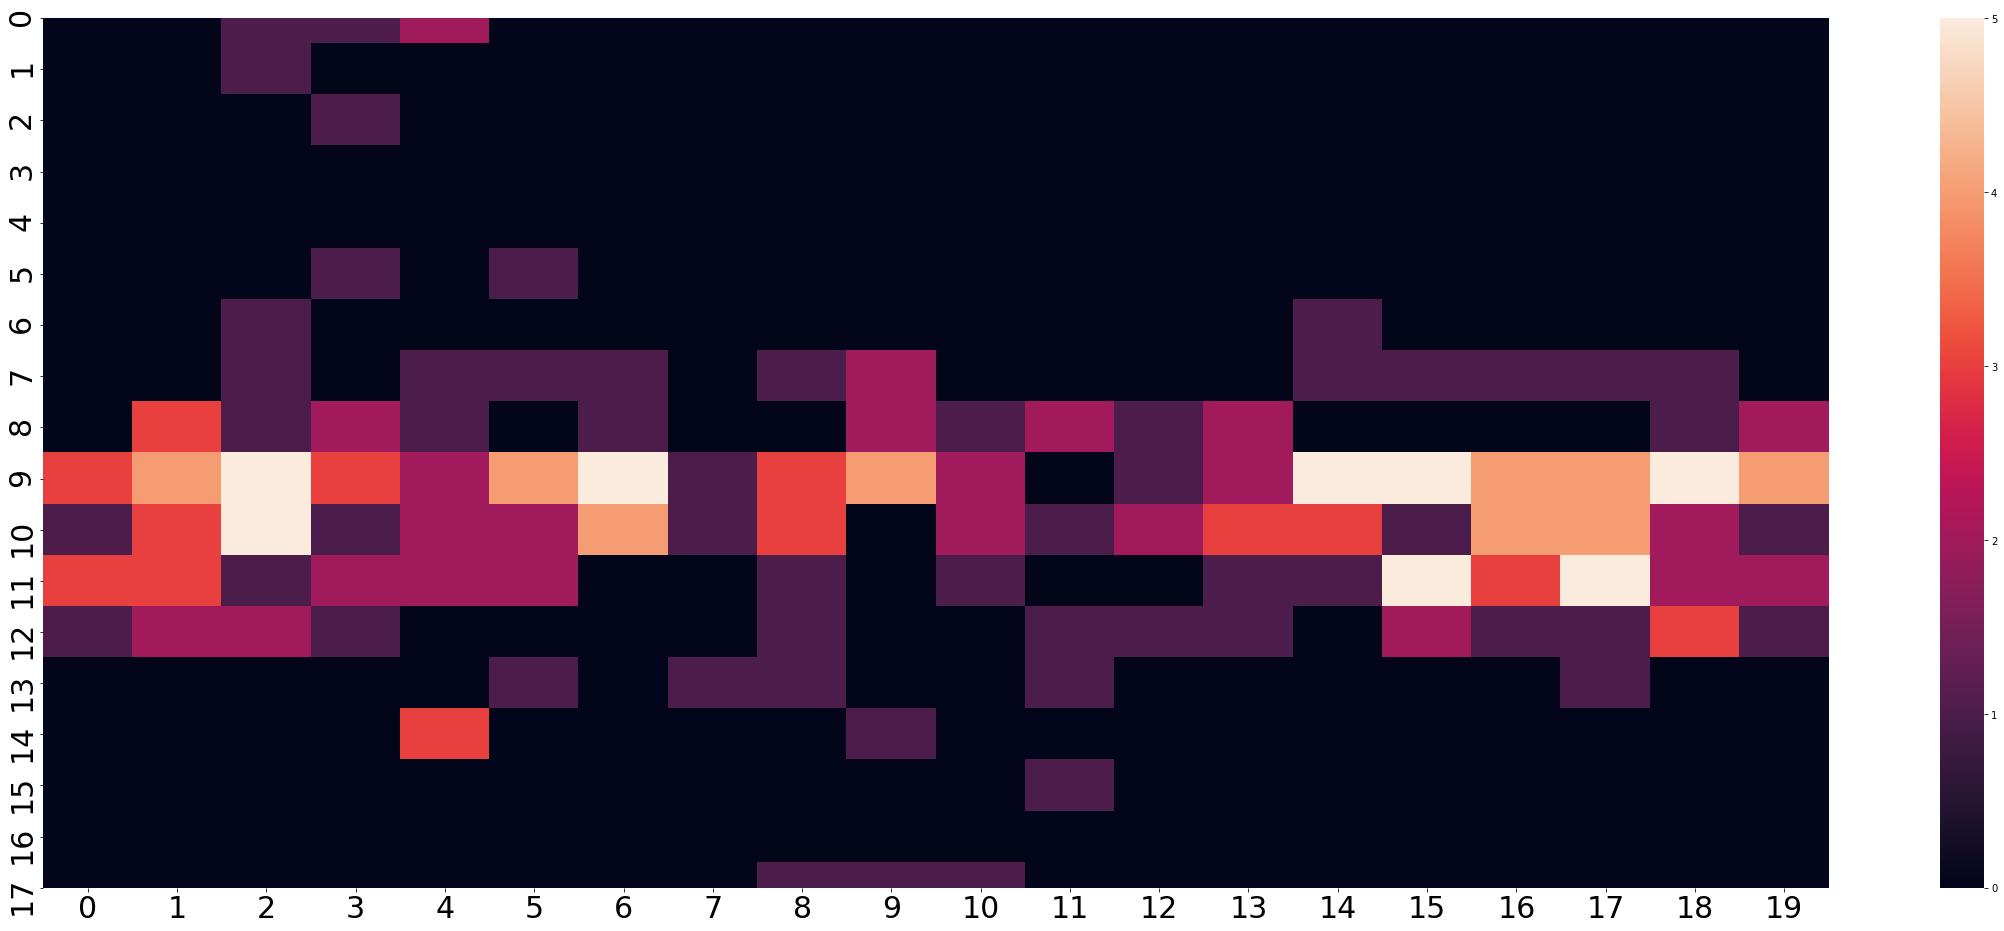

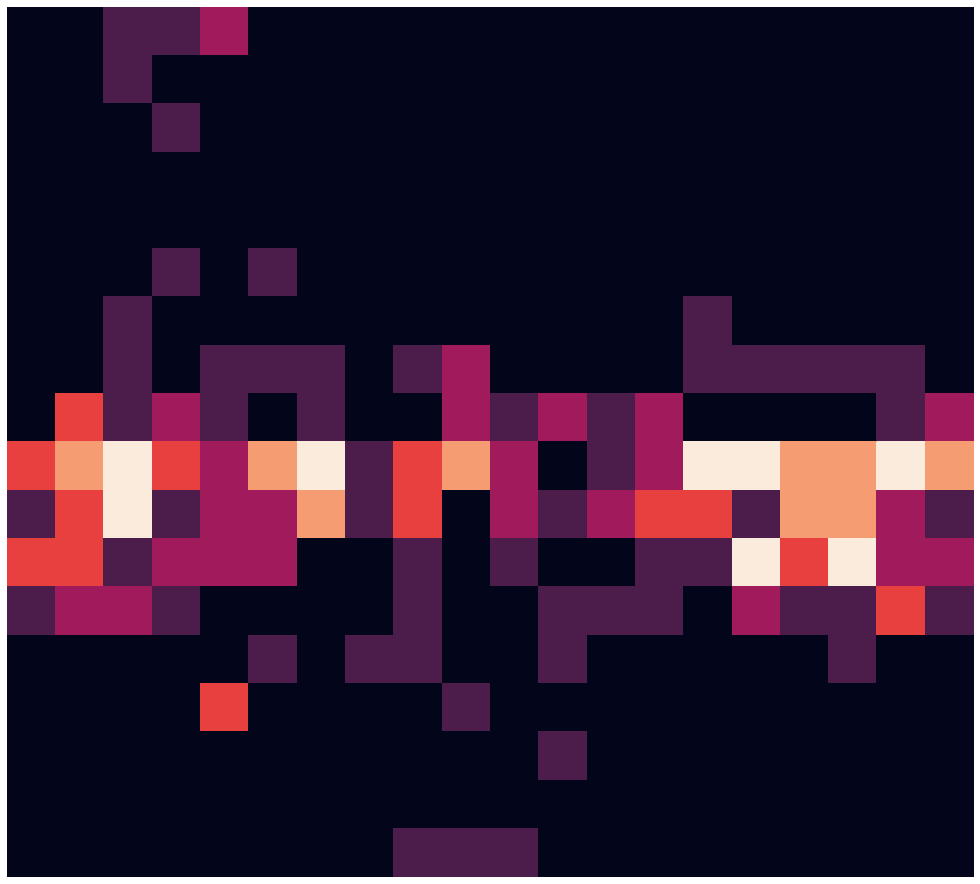

In [33]:
#blobからjsonファイル取得してヒートマップ作成
for json in json_lst:
    num = re.search(r'\d+',json)
    media_id = num.group()
    bucket_name = 'heatmap-staging'
    source_blob_name = 'heatmaps/media/'+media_id + '/heatmap.json'
    heatmaps/media/10011419
    file_name = 'data/' + media_id + '.json'
    #blobからjsonファイル取得
    download_blob(bucket_name,source_blob_name,file_name)
    
    #ヒートマップ作成
    heatmap_maker_json(file_name)
    
    os.remove(file_name)
    
    

In [24]:
df_s

,9880851
coordinate,"[[0.0, 14.000000000003185], [-1.20000000000004..."
item_id,4397602
organization_group_id,1


In [ ]:
#----------------------------------------- GCSへのアップロード -----------------------------------------------
    # Create a storage client.

    #os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/tani_kyuichiro/nurve-cloud-98b3f-bb7c97f8fb03.json'

    storage_client = google.cloud.storage.Client()

    bucket_name = 'heatmap-staging' 
    bucket = storage_client.get_bucket(bucket_name)

    source_file_name = './data/' + str(media_id) + '.json'
    destination_blob_name = 'medium_items/media/' + str(media_id) + '/heatmap.json'
    blob = bucket.blob(destination_blob_name)
 
    # Upload the local file to Cloud Storage.
    blob.upload_from_filename(source_file_name)
 
    print('File {} uploaded to {}.'.format(source_file_name,bucket))
    print('GCSへのアップロード完了') 
    
    #---------------------------------------------- ディレクトリ削除 ----------------------------------------------------------------
    #shutil.rmtree('./medium_items/media/' + media_id)

In [ ]:
df_sort = df.sort_values(['organization_group_id','media_id'])

In [ ]:
df_sort

In [ ]:
#item_idリスト作成
df_s = df['item_id']
#item_s = df_s('item_id')
#item_lst = item_s.values.tolist()
item_lst = df_s.values.tolist()
item_lst = list(set(item_lst))

In [ ]:
for id in item_lst:
    lines = df2[df2['item_id']==id].values.tolist()
    if len(lines) > 100:
        print(len(lines))
        if not heatmap_maker2(lines):
            print('---- error ----')
            continue

In [ ]:
#いずれはコマンド入力へ変更
val = 'item_id'
id = '7031202' #item_id
#val = 'media_id'
#file = '15122174'
#media_id = '13106716'

In [7]:
# -*- coding:utf-8 -*-
#ライブラリ
import os
from google.cloud import storage as gcs
import pandas as pd
from io import BytesIO

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/tani_kyuichiro/nurve-cloud-98b3f-bb7c97f8fb03.json'

bucket_name = "heatmap-staging"
file_name = "logging/heatmap.csv"
project_name = "nurve-cloud-98b3f"

# create gcs cliaent
client = gcs.Client(project_name)
bucket = client.get_bucket(bucket_name)
# create blob
blob = gcs.Blob(file_name, bucket)
content = blob.download_as_string()
train = pd.read_csv(BytesIO(content))
train.head()

,organization_group_id,media_id,item_id,x,y
0,1,365,178,-13.2,273.4
1,1,365,178,-18.2,316.4
2,1,365,178,-13.2,273.4
3,1,365,178,-19.4,331.6
4,1,366,179,0.0,122.0


In [ ]:
heatmap_maker(val,id)

In [ ]:
#GCSへのアップロード
# Create a storage client.

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/tani_kyuichiro/nurve-cloud-98b3f-bb7c97f8fb03.json'

storage_client = google.cloud.storage.Client()

bucket_name = 'rent-heatmap' 
bucket = storage_client.get_bucket(bucket_name)

source_file_name = 'medium_items/media/' + media_id + '/heatmap.jpg'
blob = bucket.blob(source_file_name)
 
# Upload the local file to Cloud Storage.
blob.upload_from_filename(source_file_name)
 
print('File {} uploaded to {}.'.format(source_file_name,bucket))
print('GCSへのアップロード完了')

In [ ]:
import datetime

dt_now = datetime.datetime.now()
today = dt_now.strftime("%Y-%m-%d")

In [ ]:
num = '6421364'
sql1 = "SELECT id as media_id, item_id ,x ,y FROM panorama_user_event t1 \
        JOIN ( SELECT id, mediumable_id FROM nurvecloud.media WHERE mediumable_type = 'Item' ) t2 \
        ON mediumable_id = item_id \
        WHERE item_id = "
sql2 = " AND x IS NOT NULL AND y IS NOT NULL  AND \
        TD_TIME_RANGE(t1.time, TD_TIME_ADD('"
sql3 = today + "','-7d','JST'),'"
sql4 = today + "', 'JST')"
sql = sql1 + num + sql2 + sql3 + sql4
print(sql)

In [ ]:
engine = td.create_engine('presto:rails_events_production')

# Read Treasure Data query into a DataFrame.
df = td.read_td(sql, engine)
lines = df.values.tolist()

In [ ]:
#一気にデータを吸い取るsql
sql1 = "WITH item_id_list as (SELECT id as media_id,t1.item_id,mediumable_id,cnt \
  ,TD_TIME_FORMAT(resent_time,'yyyy-MM-dd HH:mm:ss','JST') as jp_time \
FROM \
  (SELECT item_id,COUNT(*) as cnt FROM panorama_user_event \
  WHERE TD_TIME_RANGE(time, TD_TIME_ADD('" + today + "','-8d','JST'), '" + today + "', 'JST') \
  GROUP BY item_id \
  ORDER BY cnt DESC ) t1 \
JOIN \
  (SELECT id, mediumable_id FROM nurvecloud.media WHERE mediumable_type = 'Item') t2 ON mediumable_id = item_id \
JOIN \
  (SELECT item_id ,MAX(time) OVER(PARTITION BY item_id) as resent_time FROM panorama_user_event WHERE \
    TD_TIME_RANGE(time, TD_TIME_ADD('" + today + "','-8d','JST'), '" + today + "', 'JST')) t3 \
ON t1.item_id = t3.item_id ORDER BY resent_time DESC, cnt DESC) \
, item_id_selecter as (SELECT DISTINCT * FROM item_id_list WHERE cnt > 100)"

sql2 = "SELECT media_id,t1.item_id ,x ,y FROM panorama_user_event t1 join item_id_selecter t2 on t1.item_id = t2.item_id \
where  x IS NOT NULL AND y IS NOT NULL  AND \
TD_TIME_RANGE(time, TD_TIME_ADD('" + today + "','-8d','JST'), '" + today + "', 'JST')"

sql = sql1 + sql2

In [ ]:
engine = td.create_engine('presto:rails_events_production')

# Read Treasure Data query into a DataFrame.
df2 = td.read_td(sql, engine)
#lines2 = df2.values.tolist()

In [ ]:
#item_idリスト作成
df_s = df2['item_id']
#item_s = df_s('item_id')
#item_lst = item_s.values.tolist()
item_lst = df_s.values.tolist()
item_lst = list(set(item_lst))


In [ ]:
item_lst.sort()
for id in item_lst:
    lines = df2[df2['item_id']==id].values.tolist()
    if len(lines) > 100:
        print(len(lines))
        if not heatmap_maker2(lines):
            print('---- error ----')
            continue
    

In [ ]:
lines = df2[df2['item_id']==7225719].values.tolist()
print(type(lines))

In [ ]:
#line = lines[0]
#str(int(line[1]))
heatmap_maker2(lines)

In [ ]:
bucket_name = 'rent-production'
list_blobs(bucket_name)

In [ ]:
client = storage.Clinet()
bucket = client.get_bucket('rent-production')
blobs = bucket.list_blobs(prefix="medium_items/media/", delimiter="/")
dirs = []
for page in blobs.pages:
    dirs.extend(page.prefixes)

[ print(x) for x in dirs ]

In [ ]:
def extension_get(bucket_name,prefix):
    storage_client = storage.Client()

        # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(
            bucket_name, prefix=prefix, delimiter='/'
        )

    blob_lst = []
    target = prefix

    for blob in blobs:
        blob_lst.append(blob.name)
        print(blob.name)
    l_in = [s for s in blob_lst if target in s]

    if len(l_in) > 0:
        extension = l_in[0].replace(target,'')
        print('ext: {}'.format(extension))
        return extension
    else:
        return False

In [ ]:
    bucketname = 'rent-production'
    prefix = 'medium_items/media/'
    ext = extension_get(bucketname,prefix) #拡張子吸い出し